# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.linkedin.com/company/orenj-i/)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 39: Mean Semi Kurtosis Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'AMZN', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'AAPL', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-22 00:00:00-04:00,0.6110%,1.4325%,-1.9240%,-0.0786%,-0.6335%,-6.2983%,-0.6392%,-1.1024%,0.0528%,-0.3221%,...,-1.0331%,0.8927%,-0.8661%,0.4483%,-2.8972%,-0.6085%,-0.6075%,-0.8635%,0.1457%,-3.4490%
2018-10-23 00:00:00-04:00,0.9427%,-1.1513%,-3.6571%,-1.6658%,-0.4202%,-0.4520%,-0.2797%,-0.5034%,0.1844%,-3.9948%,...,0.8808%,-1.3956%,0.4766%,-5.1240%,-0.0321%,1.0713%,-1.0807%,-1.8308%,4.0560%,4.0353%
2018-10-24 00:00:00-04:00,-3.4302%,-5.9083%,-4.5500%,1.3141%,-1.8042%,-3.5933%,-4.2917%,0.8674%,0.9995%,-4.1109%,...,0.7437%,-5.3469%,3.5178%,-4.2683%,-1.3479%,-8.0557%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25 00:00:00-04:00,2.1898%,7.0887%,0.4741%,2.5715%,0.5186%,0.7782%,5.0410%,-0.5733%,-1.1718%,2.1585%,...,1.3642%,5.8444%,-1.0309%,0.4914%,0.9109%,-1.2516%,4.3662%,1.3800%,-1.7241%,3.3538%
2018-10-26 00:00:00-04:00,-1.5924%,-7.8197%,-1.9921%,-1.2370%,-1.0908%,2.4792%,-1.6741%,-2.0901%,-3.2148%,-2.7636%,...,-0.1108%,-1.2373%,-1.8518%,0.1449%,1.0316%,-2.9686%,-0.0825%,-0.4102%,-1.6303%,-1.2513%


## 2. Estimating Mean Semi Kurtosis Portfolios

The Semi Kurtosis portfolio model proposed by __[Cajas (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3988927)__ shows how to optimize the fourth lower moment of portfolio returns using an lower semi cokurtosis matrix as an heuristic in a similar way than lower semi covariance matrix. 

It is recommended to use MOSEK to optimize Kurtosis for a large number of assets due the model use semidefinite programming. Also, for a large number of assets is recommended to use the relaxed version of this model based only on second order cone programming. To use the relaxed version we have to use a number of assets higher than the property __n_max_kurt__, so for example if number of assets is 30 and we set __port.n_max_kurt = 25__, riskfolio-lib is going to use the relaxed version.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

### 2.1 Calculating the portfolio that optimize return/semi kurtosis ratio.

In [3]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
method_kurt='hist' # Method to estimate cokurtosis square matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  method_kurt=method_kurt,
                  )

# Estimate optimal portfolio:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

model ='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'SKT' # Risk measure used, this time will be Tail Gini Range
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

You must convert self.kurt to a positive definite matrix
You must convert self.skurt to a positive definite matrix


,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.4386%,1.9208%,0.0000%,8.4047%,0.0000%,...,0.0000%,0.0000%,0.0000%,4.6261%,6.0600%,0.0000%,6.4517%,0.0000%,28.0045%,0.0000%


### 2.2 Plotting portfolio composition

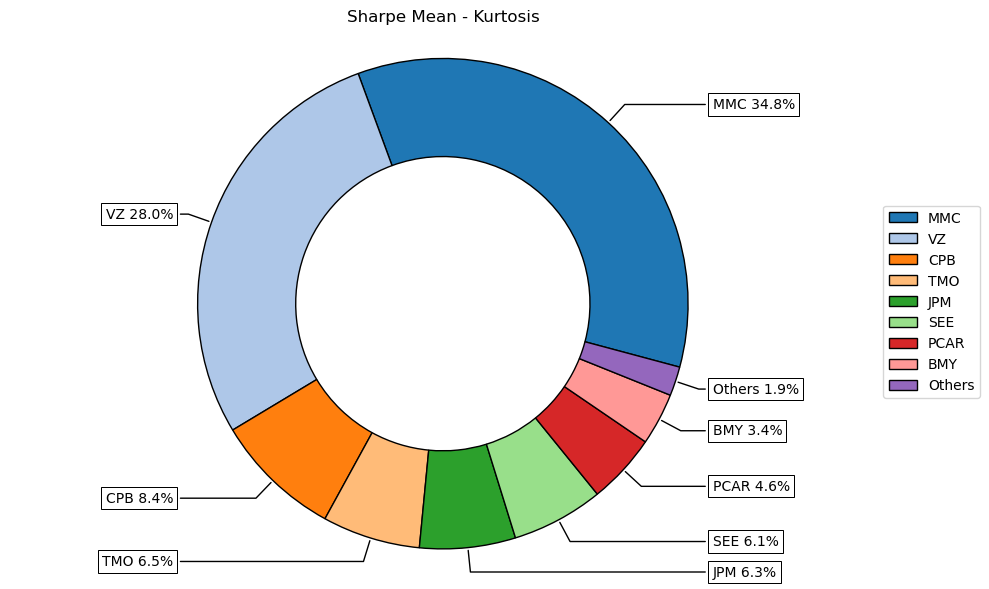

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Sharpe Mean - Kurtosis',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

### 2.3 Plotting risk measures

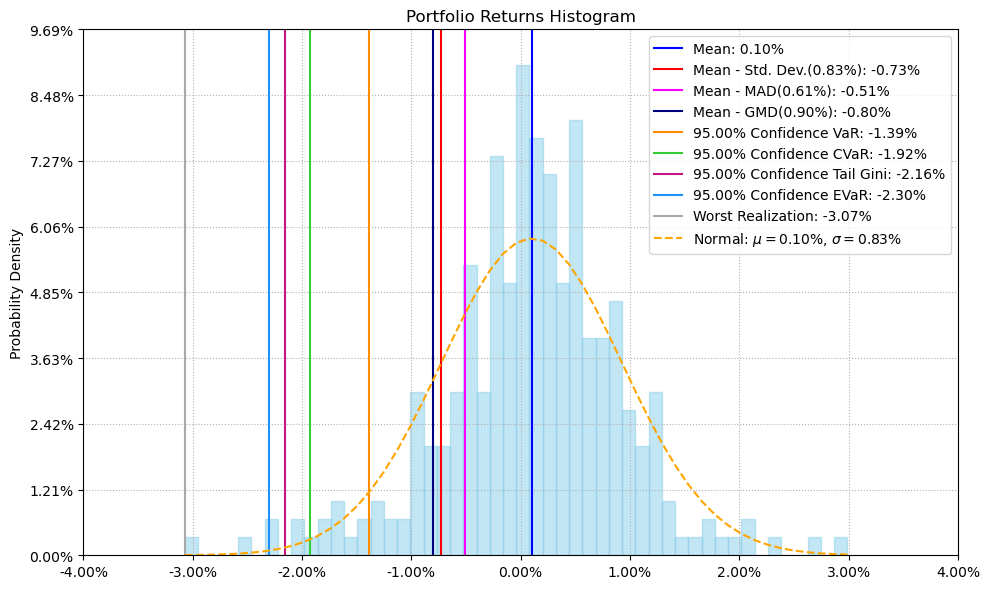

In [5]:
ax = rp.plot_hist(returns=Y,
                  w=w,
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

### 2.4 Calculate efficient frontier

In [6]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

The problem doesn't have a solution with actual input parameters


,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.0000%,0.0000%,1.3643%,6.2283%,12.0033%,16.7392%,0.0000%,0.0000%,...,10.3350%,0.0000%,5.6256%,0.0000%,8.8185%,0.0000%,0.0000%,0.0000%,28.2749%,0.0000%
1,0.0000%,0.0000%,0.0000%,0.0000%,1.2878%,6.0947%,11.3426%,11.4999%,0.0000%,0.0000%,...,5.5357%,0.0000%,6.1890%,0.0000%,9.3923%,0.0000%,0.0000%,0.0000%,30.1659%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%,1.1671%,5.9042%,9.1155%,3.3837%,0.0000%,0.0000%,...,0.0000%,0.0000%,8.2168%,0.0000%,10.1462%,0.0000%,0.0000%,0.0000%,32.9716%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.8247%,5.6407%,6.2066%,0.0001%,3.8395%,0.0000%,...,0.0000%,0.0000%,4.5035%,0.0001%,8.8214%,0.0001%,0.8763%,0.0000%,32.7956%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0704%,4.9449%,4.2245%,0.0000%,6.9038%,0.0000%,...,0.0000%,0.0000%,0.0003%,0.0001%,7.1492%,0.0000%,3.5281%,0.0000%,31.7772%,0.0000%


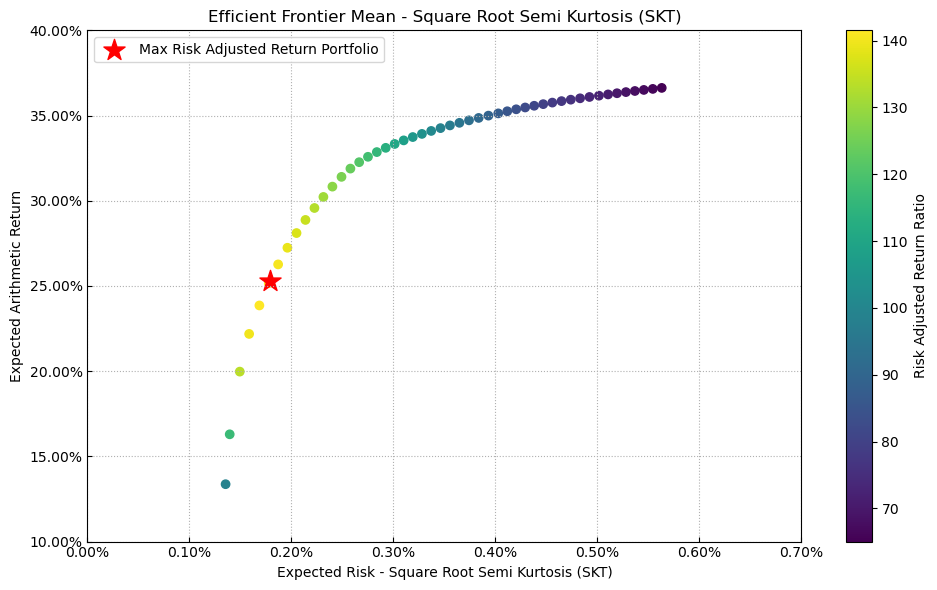

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

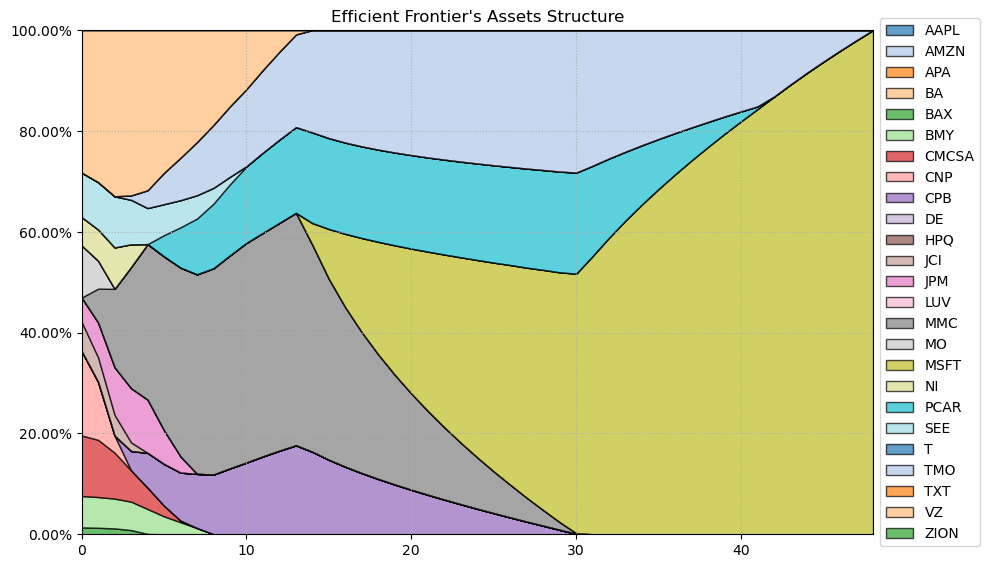

In [8]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for Square Root Semi Kurtosis

### 3.1 Calculating the risk parity portfolio for Square Root Semi Kurtosis.

In [9]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,2.5367%,2.6981%,2.4337%,3.6063%,4.2654%,3.9901%,4.0326%,6.5094%,4.6418%,2.5381%,...,5.6729%,2.9164%,5.8980%,3.4444%,4.6115%,3.9454%,3.5651%,3.1972%,7.6413%,3.4828%


### 3.2 Plotting portfolio composition

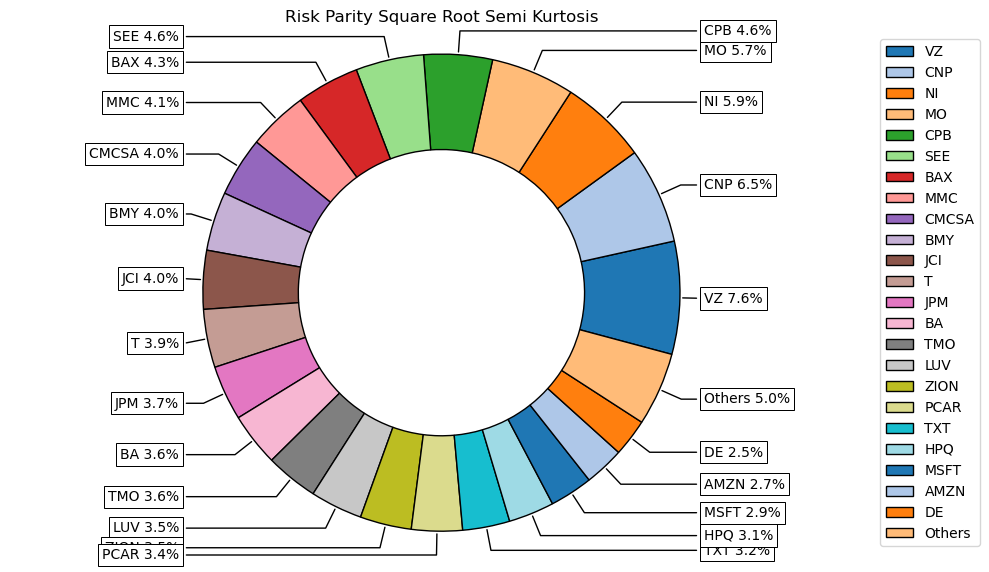

In [10]:
ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity Square Root Semi Kurtosis',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)

### 3.3 Plotting Risk Composition

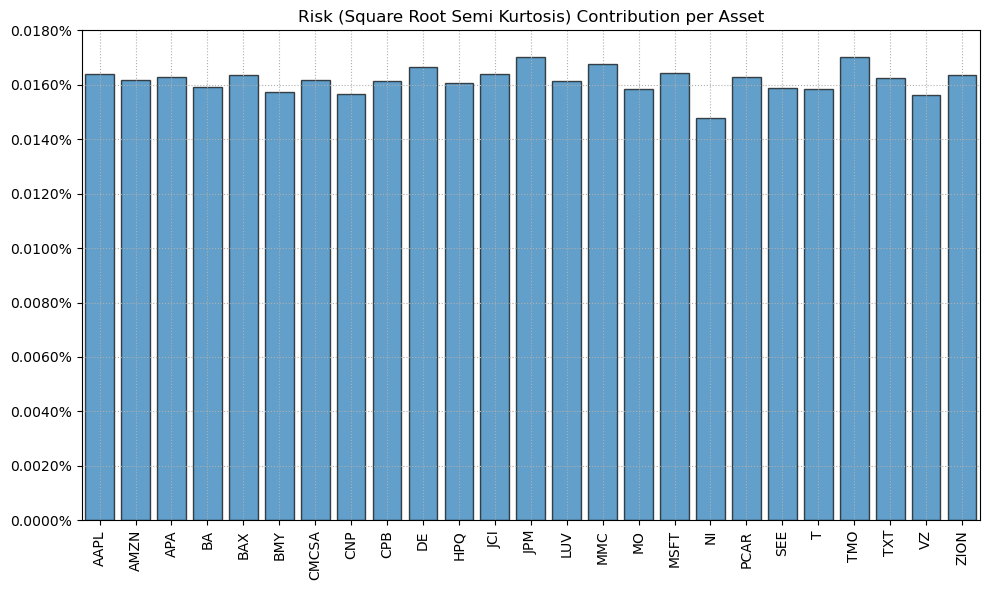

In [11]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=10, ax=None)

Due to semi kurtosis use an heuristic based on lower semi cokurtosis matrix to approach portfolio lower semi kurtosis, the solution is only an approximation.

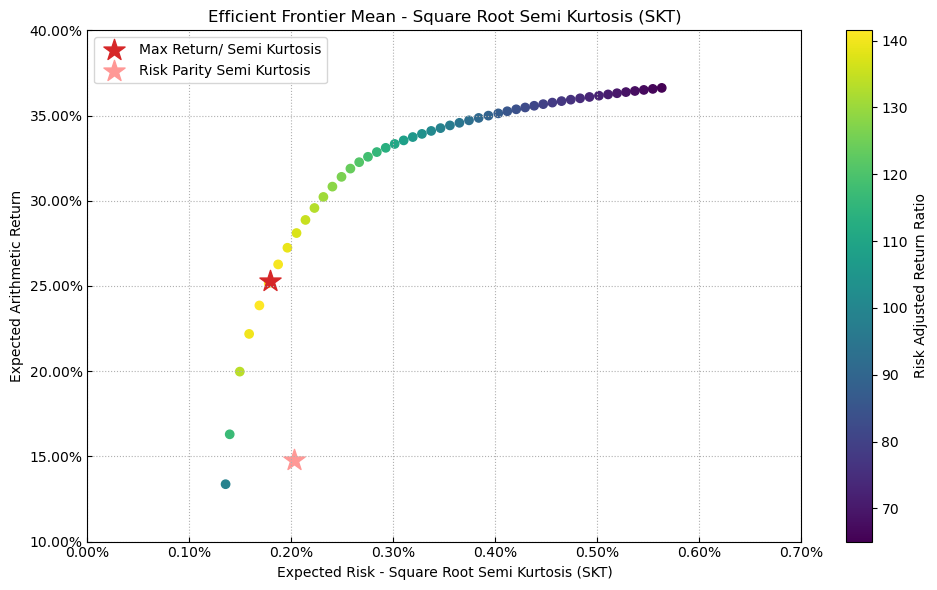

In [12]:
# Plotting the efficient frontier
ws = pd.concat([w, w_rp],axis=1)
ws.columns = ["Max Return/ Semi Kurtosis", "Risk Parity Semi Kurtosis"]

mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=ws,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)